In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import timm

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from pyts.image import GramianAngularField, MarkovTransitionField
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## Vision Transformer Function

In [2]:
# Create NumpyDataset class for using with ViT
class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data[:, :, :, :3].astype(np.float32) # Select only RGB channel
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Swap from (Height, Width, Channel) to (Channel, Width, Height)
])

In [4]:
def evaluate(model, dataloader, device):
    model.eval() 
    all_predictions = []

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) # Get class with the highest probability
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_predictions)

In [5]:
X_train_normalized = np.load('E:/thesis project/thesis_proj/X_train_normalized.npy')
X_test_normalized = np.load('E:/thesis project/thesis_proj/X_test_normalized.npy')
X_train_normalized = np.load('E:/thesis project/thesis_proj/X_train_normalized.npy')
X_train_normalized_aug = np.load('E:/thesis project/thesis_proj/X_train_normalized_aug.npy')
y1_test = np.load('E:/thesis project/thesis_proj/y1_test.npy')
y1_train = np.load('E:/thesis project/thesis_proj/y1_train.npy')
y_train_int_aug = np.load('E:/thesis project/thesis_proj/y_train_int_aug.npy')
# For model
EPOCH = 30
BATCHSIZE = 32
VAL = 0.2
BASE = 'E:/thesis project/thesis_proj/'
PLOTSIZE = 224 # Size of GAF and MTF image
IMAGESIZE = 224 # Size of image loaded from buffer

In [6]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

## Label Encoder

In [7]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

In [8]:
y_train = []

for y in y1_train:
    if y in benign:
        y_train.append('Benign')
    else:
        y_train.append('Ransomware')

In [9]:
y_test = []

for y in y1_test:
    if y in benign:
        y_test.append('Benign')
    else:
        y_test.append('Ransomware')

In [10]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
lbl = LabelEncoder()

In [12]:
classes, count = np.unique(y_train, return_counts=True)
print(classes)
print(count)

['Benign' 'Ransomware']
[160 672]


In [13]:
print(lbl.fit_transform(classes), classes)
y_train_int = lbl.fit_transform(y_train)
y_train_int.shape

[0 1] ['Benign' 'Ransomware']


(832,)

In [14]:
classes_test, count_test = np.unique(y_test, return_counts=True)
print(classes_test)
print(count_test)

['Benign' 'Ransomware']
[ 41 171]


In [15]:
y_test_int = lbl.transform(y_test)
y_test_int.shape

(212,)

In [16]:
SEED = 42

In [17]:
NUMCLASS = len(classes)

# Image as an Input

In [18]:
PLOTSIZE = 16 # Size of GAF and MTF image
IMAGESIZE = 64 # Size of image loaded from buffer

In [19]:
data_train_transposed = np.transpose(X_train_normalized, (0, 2, 1))
data_train_transposed.shape

(832, 5, 16)

In [20]:
data_train_aug_transposed = np.transpose(X_train_normalized_aug, (0, 2, 1))
data_train_aug_transposed.shape

(1344, 5, 16)

In [21]:
data_test_transposed = np.transpose(X_test_normalized, (0, 2, 1))
data_test_transposed.shape

(212, 5, 16)

## Correlation Matrix

In [22]:
contour_train_tmp = []

for i in range(data_train_transposed.shape[0]):
    df = pd.DataFrame({
        'Feature1': data_train_transposed[i, 0, :],
        'Feature2': data_train_transposed[i, 1, :],
        'Feature3': data_train_transposed[i, 2, :],
        'Feature4': data_train_transposed[i, 3, :],
        'Feature5': data_train_transposed[i, 4, :]
        })
    cor = df.corr()

    X, Y = np.meshgrid(range(cor.shape[1]), range(cor.shape[0]))
    Z = cor.values

    plt.figure(figsize=(6, 6))
    plt.contourf(X, Y, Z)
    plt.contour(X, Y, Z, colors='black')
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    contour_train_tmp.append(image_array)

In [23]:
contour_train = np.stack(contour_train_tmp, axis=0)
contour_train = contour_train/255
contour_train.shape

(832, 64, 64, 4)

In [24]:
contour_train_aug_tmp = []

for i in range(data_train_aug_transposed.shape[0]):
    df = pd.DataFrame({
        'Feature1': data_train_aug_transposed[i, 0, :],
        'Feature2': data_train_aug_transposed[i, 1, :],
        'Feature3': data_train_aug_transposed[i, 2, :],
        'Feature4': data_train_aug_transposed[i, 3, :],
        'Feature5': data_train_aug_transposed[i, 4, :]
        })
    cor = df.corr()

    X, Y = np.meshgrid(range(cor.shape[1]), range(cor.shape[0]))
    Z = cor.values

    plt.figure(figsize=(6, 6))
    plt.contourf(X, Y, Z)
    plt.contour(X, Y, Z, colors='black')
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    contour_train_aug_tmp.append(image_array)

In [25]:
contour_train_aug = np.stack(contour_train_aug_tmp, axis=0)
contour_train_aug = contour_train_aug/255
contour_train_aug.shape

(1344, 64, 64, 4)

In [26]:
contour_test_tmp = []

for i in range(data_test_transposed.shape[0]):
    df = pd.DataFrame({
        'Feature1': data_test_transposed[i, 0, :],
        'Feature2': data_test_transposed[i, 1, :],
        'Feature3': data_test_transposed[i, 2, :],
        'Feature4': data_test_transposed[i, 3, :],
        'Feature5': data_test_transposed[i, 4, :]
        })
    cor = df.corr()

    X, Y = np.meshgrid(range(cor.shape[1]), range(cor.shape[0]))
    Z = cor.values

    plt.figure(figsize=(6, 6))
    plt.contourf(X, Y, Z)
    plt.contour(X, Y, Z, colors='black')
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    contour_test_tmp.append(image_array)

In [27]:
contour_test = np.stack(contour_test_tmp, axis=0)
contour_test = contour_test/255
contour_test.shape

(212, 64, 64, 4)

### CNN

In [28]:
tf.random.set_seed(SEED)
cnn_contour = Sequential(name='CNN_Contour')
cnn_contour.add(Conv2D(32, (3, 3), activation='relu', input_shape=(contour_train.shape[1], contour_train.shape[2], contour_train.shape[3])))
cnn_contour.add(MaxPooling2D((2, 2)))
cnn_contour.add(Dropout(0.2))
cnn_contour.add (Conv2D(16, (3, 3), activation='relu'))
cnn_contour.add(MaxPooling2D((2, 2)))
cnn_contour.add(Dropout(0.2))
cnn_contour.add (Conv2D(8, (3, 3), activation='relu'))
cnn_contour.add(Flatten())
cnn_contour.add(Dense(8, activation='relu'))
cnn_contour.add(Dense(NUMCLASS, activation='softmax'))

cnn_contour.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
cnn_contour.summary()

Model: "CNN_Contour"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         9,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,210 (63.32 KB)

 Trainable params: 16,210 (63.32 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
tf.random.set_seed(SEED)
cnn_contour_history = cnn_contour.fit(contour_train, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7933 - loss: 0.5594 - val_accuracy: 0.8084 - val_loss: 0.4850
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5240 - val_accuracy: 0.8084 - val_loss: 0.4864
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7985 - loss: 0.5139 - val_accuracy: 0.8084 - val_loss: 0.4885
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7985 - loss: 0.5102 - val_accuracy: 0.8084 - val_loss: 0.4862
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7985 - loss: 0.5049 - val_accuracy: 0.8084 - val_loss: 0.4797
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5034 - val_accuracy: 0.8084 - val_loss: 0.4761
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7985 - loss: 0.5029 - val_accuracy: 0.8084 - val_loss: 0.4748
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.4909 - val_accuracy: 0.8084 - va

In [31]:
cnn_contour.save(f'{BASE}/Models/cnn_contour.h5')

### CNN with SMOTE

In [32]:
tf.random.set_seed(SEED)
cnn_contour_aug = Sequential(name='CNN_Contour_aug')
cnn_contour_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(contour_train_aug.shape[1], contour_train_aug.shape[2], contour_train_aug.shape[3])))
cnn_contour_aug.add(MaxPooling2D((2, 2)))
cnn_contour_aug.add(Dropout(0.2))
cnn_contour_aug.add (Conv2D(16, (3, 3), activation='relu'))
cnn_contour_aug.add(MaxPooling2D((2, 2)))
cnn_contour_aug.add(Dropout(0.2))
cnn_contour_aug.add (Conv2D(8, (3, 3), activation='relu'))
cnn_contour_aug.add(Flatten())
cnn_contour_aug.add(Dense(8, activation='relu'))
cnn_contour_aug.add(Dense(NUMCLASS, activation='softmax'))

cnn_contour_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
cnn_contour_aug.summary()

Model: "CNN_Contour_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         9,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,210 (63.32 KB)

 Trainable params: 16,210 (63.32 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
tf.random.set_seed(SEED)
cnn_contour_aug_history = cnn_contour_aug.fit(contour_train_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5940 - loss: 0.6777 - val_accuracy: 0.0000e+00 - val_loss: 0.8812
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6144 - loss: 0.6652 - val_accuracy: 0.0000e+00 - val_loss: 0.8893
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6144 - loss: 0.6560 - val_accuracy: 0.0000e+00 - val_loss: 0.8875
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6144 - loss: 0.6432 - val_accuracy: 0.0000e+00 - val_loss: 0.8492
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6144 - loss: 0.6373 - val_accuracy: 0.0000e+00 - val_loss: 0.8470
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6144 - loss: 0.6371 - val_accuracy: 0.0000e+00 - val_loss: 0.8495
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6144 - loss: 0.6348 - val_accuracy: 0.0000e+00 - val_loss: 0.8507
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6144 - loss: 0.6315 - va

In [35]:
cnn_contour_aug.save(f'{BASE}/Models/cnn_contour_aug.h5')

### ViT

In [36]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
contour_train_dataloader = DataLoader(NumpyDataset(contour_train, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
contour_test_dataloader = DataLoader(NumpyDataset(contour_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [37]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_contour = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_contour.head = nn.Linear(vit_contour.head.in_features, NUMCLASS)
vit_contour = vit_contour.to(device)

In [38]:
for param in vit_contour.parameters():
    param.requires_grad = False
for param in vit_contour.head.parameters():
    param.requires_grad = True

In [39]:
total_params = sum(p.numel() for p in vit_contour.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_contour.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [40]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_contour.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_contour.train()
    running_loss = 0

    for inputs, labels in contour_train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_contour(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(contour_train_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.6174
Epoch 2/30, Loss: 0.5015
Epoch 3/30, Loss: 0.4823
Epoch 4/30, Loss: 0.4725
Epoch 5/30, Loss: 0.4642
Epoch 6/30, Loss: 0.4571
Epoch 7/30, Loss: 0.4507
Epoch 8/30, Loss: 0.4449
Epoch 9/30, Loss: 0.4395
Epoch 10/30, Loss: 0.4346
Epoch 11/30, Loss: 0.4301
Epoch 12/30, Loss: 0.4258
Epoch 13/30, Loss: 0.4219
Epoch 14/30, Loss: 0.4181
Epoch 15/30, Loss: 0.4146
Epoch 16/30, Loss: 0.4113
Epoch 17/30, Loss: 0.4082
Epoch 18/30, Loss: 0.4052
Epoch 19/30, Loss: 0.4023
Epoch 20/30, Loss: 0.3996
Epoch 21/30, Loss: 0.3970
Epoch 22/30, Loss: 0.3945
Epoch 23/30, Loss: 0.3921
Epoch 24/30, Loss: 0.3897
Epoch 25/30, Loss: 0.3875
Epoch 26/30, Loss: 0.3853
Epoch 27/30, Loss: 0.3832
Epoch 28/30, Loss: 0.3812
Epoch 29/30, Loss: 0.3792
Epoch 30/30, Loss: 0.3772


In [41]:
torch.save(vit_contour.state_dict(), f'{BASE}/Models/vit_contour.pth')

### ViT with SMOTE

In [42]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
contour_train_aug_dataloader = DataLoader(NumpyDataset(contour_train_aug, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [43]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_contour_aug = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_contour_aug.head = nn.Linear(vit_contour_aug.head.in_features, NUMCLASS)
vit_contour_aug = vit_contour_aug.to(device)

In [44]:
for param in vit_contour_aug.parameters():
    param.requires_grad = False
for param in vit_contour_aug.head.parameters():
    param.requires_grad = True

In [45]:
total_params = sum(p.numel() for p in vit_contour_aug.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_contour_aug.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [46]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_contour_aug.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_contour_aug.train()
    running_loss = 0

    for inputs, labels in contour_train_aug_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_contour_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(contour_train_aug_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.5266
Epoch 2/30, Loss: 2.7990
Epoch 3/30, Loss: 3.8418
Epoch 4/30, Loss: 3.3197
Epoch 5/30, Loss: 3.0544
Epoch 6/30, Loss: 2.9075
Epoch 7/30, Loss: 2.7979
Epoch 8/30, Loss: 2.7075
Epoch 9/30, Loss: 2.6297
Epoch 10/30, Loss: 2.5621
Epoch 11/30, Loss: 2.5032
Epoch 12/30, Loss: 2.4522
Epoch 13/30, Loss: 2.4078
Epoch 14/30, Loss: 2.3690
Epoch 15/30, Loss: 2.3349
Epoch 16/30, Loss: 2.3044
Epoch 17/30, Loss: 2.2770
Epoch 18/30, Loss: 2.2520
Epoch 19/30, Loss: 2.2291
Epoch 20/30, Loss: 2.2081
Epoch 21/30, Loss: 2.1887
Epoch 22/30, Loss: 2.1708
Epoch 23/30, Loss: 2.1542
Epoch 24/30, Loss: 2.1389
Epoch 25/30, Loss: 2.1247
Epoch 26/30, Loss: 2.1115
Epoch 27/30, Loss: 2.0993
Epoch 28/30, Loss: 2.0880
Epoch 29/30, Loss: 2.0775
Epoch 30/30, Loss: 2.0676


In [47]:
torch.save(vit_contour_aug.state_dict(), f'{BASE}/Models/vit_contour_aug.pth')

### Evaluation

#### CNN

In [48]:
tf.random.set_seed(SEED)
cnn_contour_pred = cnn_contour.predict(contour_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [49]:
cnn_contour_pred_int = np.argmax(cnn_contour_pred, axis=1)

In [50]:
print('Accuracy:', accuracy_score(y_test_int, cnn_contour_pred_int))
print('Precision:', precision_score(y_test_int, cnn_contour_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_contour_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_contour_pred_int, average='macro'))

Accuracy: 0.8066037735849056
Precision: 0.4033018867924528
Recall: 0.5
F1-Score: 0.4464751958224543


C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


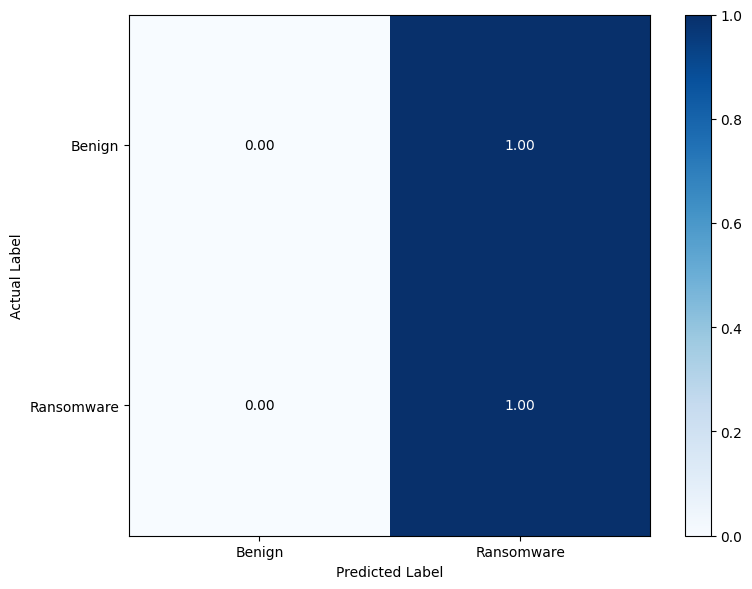

In [51]:
confusionMatrix_cnn_contour = confusion_matrix(y_test_int, cnn_contour_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_contour, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_contour.shape[0]):
    for j in range(confusionMatrix_cnn_contour.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_contour[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_contour[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### CNN with SMOTE

In [52]:
tf.random.set_seed(SEED)
cnn_contour_aug_pred = cnn_contour_aug.predict(contour_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [53]:
cnn_contour_aug_pred_int = np.argmax(cnn_contour_aug_pred, axis=1)

In [54]:
print('Accuracy:', accuracy_score(y_test_int, cnn_contour_aug_pred_int))
print('Precision:', precision_score(y_test_int, cnn_contour_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_contour_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_contour_aug_pred_int, average='macro'))

Accuracy: 0.7405660377358491
Precision: 0.6671826625386997
Recall: 0.7464698331193838
F1-Score: 0.6753807177259946


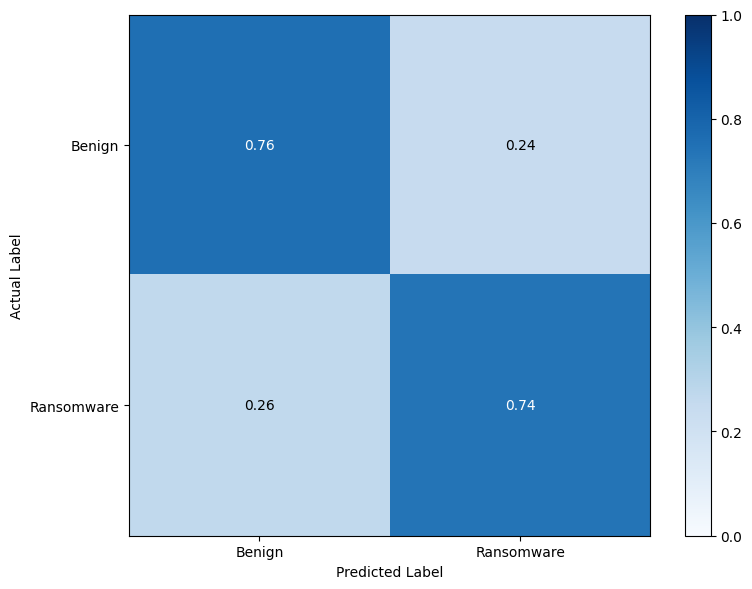

In [55]:
confusionMatrix_cnn_contour_aug = confusion_matrix(y_test_int, cnn_contour_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_contour_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_contour_aug.shape[0]):
    for j in range(confusionMatrix_cnn_contour_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_contour_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_contour_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT

In [56]:
vit_contour_pred_int = evaluate(vit_contour, contour_test_dataloader, device)

In [57]:
print('Accuracy:', accuracy_score(y_test_int, vit_contour_pred_int))
print('Precision:', precision_score(y_test_int, vit_contour_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_contour_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_contour_pred_int, average='macro'))

Accuracy: 0.8066037735849056
Precision: 0.6593137254901961
Recall: 0.5370845813721296
F1-Score: 0.5269659863945578


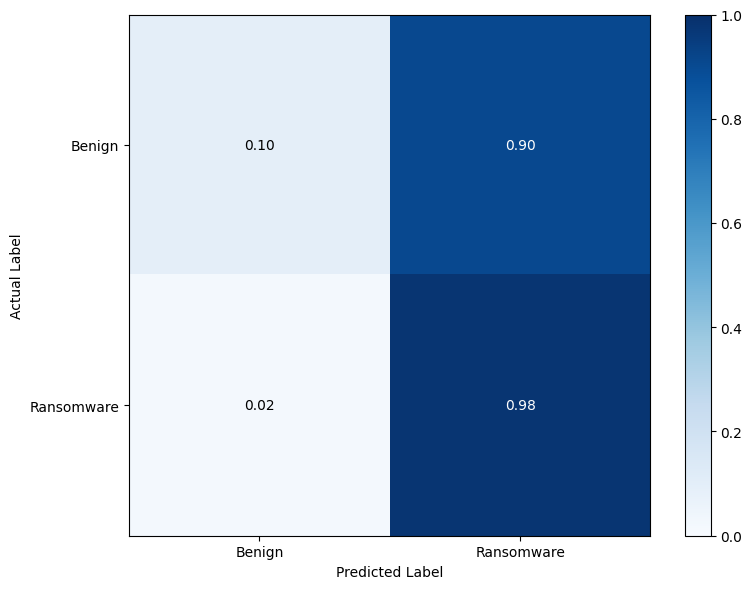

In [58]:
confusionMatrix_vit_contour = confusion_matrix(y_test_int, vit_contour_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_contour, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_contour.shape[0]):
    for j in range(confusionMatrix_vit_contour.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_contour[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_contour[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT with SMOTE

In [59]:
vit_contour_aug_pred_int = evaluate(vit_contour_aug, contour_test_dataloader, device)

In [60]:
print('Accuracy:', accuracy_score(y_test_int, vit_contour_aug_pred_int))
print('Precision:', precision_score(y_test_int, vit_contour_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_contour_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_contour_aug_pred_int, average='macro'))

Accuracy: 0.23113207547169812
Precision: 0.6004901960784313
Recall: 0.5233918128654971
F1-Score: 0.21203967620567782


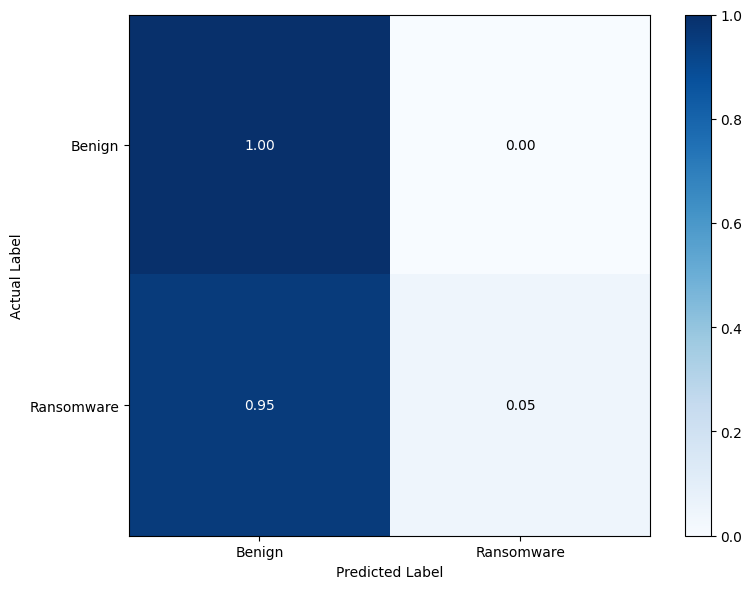

In [61]:
confusionMatrix_vit_contour_aug = confusion_matrix(y_test_int, vit_contour_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_contour_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_contour_aug.shape[0]):
    for j in range(confusionMatrix_vit_contour_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_contour_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_contour_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()